In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import constants
from numpy import random

import warnings
warnings.filterwarnings("ignore", message=r"elementwise", category=FutureWarning)
warnings.filterwarnings("ignore", message=r"deprecated", category=DeprecationWarning)

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

### Task 1

In [3]:
def decay_p(t, tau):
    """callable function for decay process

    Args:
        t   : time       - independent variable
        tau : half-lieve - parameter
    """
    return 1-2**(-t/tau)

In [4]:
N_tl = 1000     # number of initial Thallium atoms 
tau  = 3.052*60 # half-lieve in seconds 
N_t  = 1500     # number of time steps

time_grid = np.arange(0, N_t, 1)
x         = random.rand(N_tl)

tl_data = np.empty(N_t)
pb_data = np.empty(N_t)

for t in time_grid:
    p = decay_p(t, tau)                 # compute probability
    survived_tl = x[(x > p)]            # find survived Tl atoms
    n_survived = survived_tl.shape[0]   # find the number of survived Tl atoms
    tl_data[t] = n_survived             # save the number of survived Tl atoms
    pb_data[t] = N_tl - n_survived      # save the number of formed Pb atoms

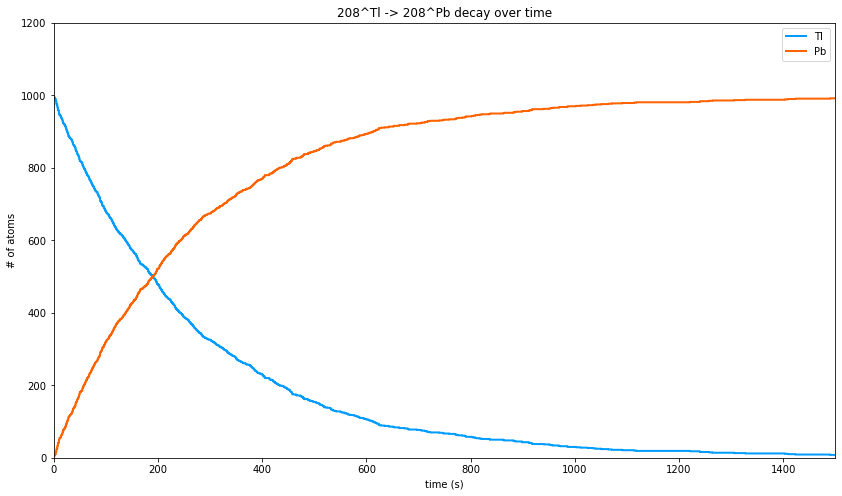

In [5]:
# I'm going to plot histograms because it is more appropriate given the observable we are visualizing 
# In this case though a line plot would be fine too since we are looking at a trend over time 
# we set binswith = 1 to visualize the same trend over time with histograms

fig, ax = plt.subplots(figsize=(14,8))

ax.set_title("208^Tl -> 208^Pb decay over time")
ax.set_xlabel("time (s)")
ax.set_ylabel("# of atoms")

ax.set_xlim(time_grid[0], time_grid[-1])
ax.set_ylim(0, N_tl * 1.2)

sns.histplot(
    x       = time_grid,
    weights = tl_data,
    bins    = time_grid+1,
    element = "step",
    fill    = False,
    lw      = 2,
    color   = "#009CFF",
    label   = "Tl"
)
sns.histplot(
    x=time_grid,
    weights=pb_data,
    bins=time_grid+1,
    element="step",
    fill=False,
    lw    = 2,
    color = "#ff6300",
    label = "Pb"
)


plt.legend()
plt.show()

In [6]:
def f(z, tau):
    return -tau*np.log2(1-z)

In [7]:
N_tl = 1000     # number of initial Thallium atoms 
tau  = 3.052*60 # half-lieve in seconds 
N_t  = 1500     # number of time steps

time_grid = np.arange(0, N_t, 1)
z         = random.rand(N_tl)
w         = f(z, tau)

tl_data_inv = np.empty(N_t)

for t in time_grid:
    survived_tl = w[w>t]                # find survived Tl atoms
    n_survived = survived_tl.shape[0]   # find the number of survived Tl atoms
    tl_data_inv[t] = n_survived             # save the number of survived Tl atoms

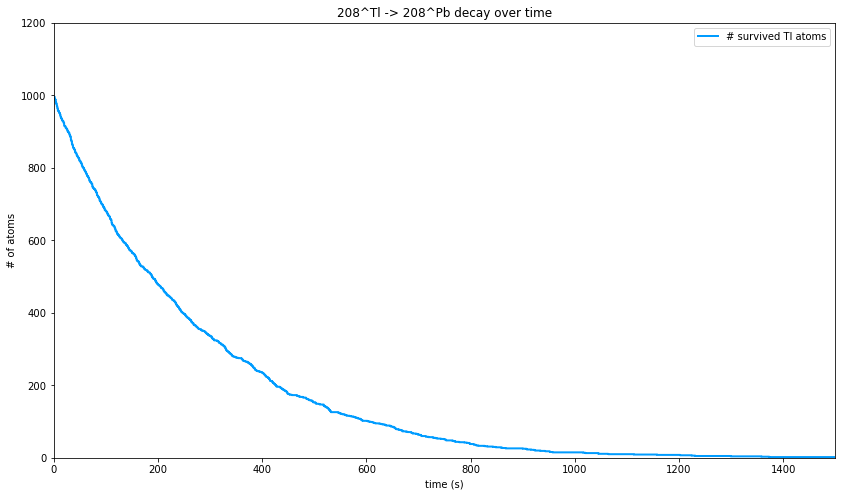

In [8]:
fig, ax = plt.subplots(figsize=(14,8))

ax.set_title("208^Tl -> 208^Pb decay over time")
ax.set_xlabel("time (s)")
ax.set_ylabel("# of atoms")

ax.set_xlim(time_grid[0], time_grid[-1])
ax.set_ylim(0, N_tl * 1.2)


sns.histplot(
    x       = time_grid,
    weights = tl_data_inv,
    bins    = time_grid+1,
    element = "step",
    fill    = False,
    lw      = 2,
    color   = "#009CFF",
    label   = "# survived Tl atoms"
)


plt.legend()
plt.show()

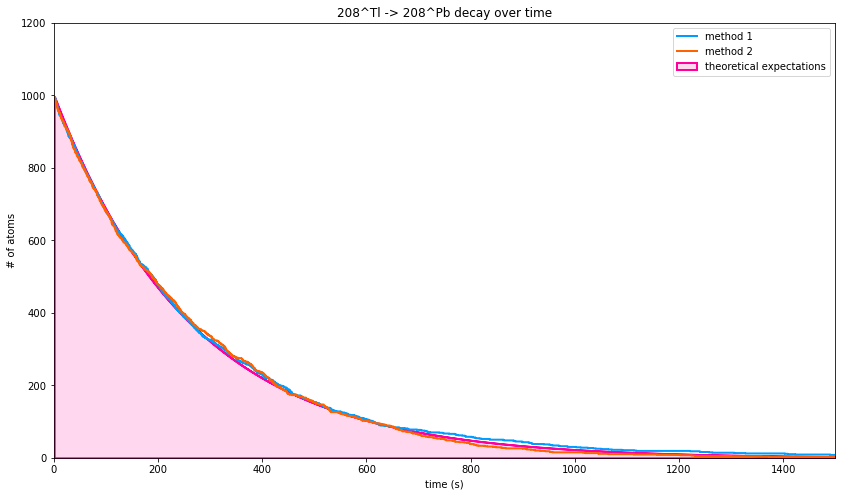

In [9]:
# let's compare the two methods with the theoretical expectation
tl_data_th = 1000*(2**(-time_grid/tau))

fig, ax = plt.subplots(figsize=(14,8))

ax.set_title("208^Tl -> 208^Pb decay over time")
ax.set_xlabel("time (s)")
ax.set_ylabel("# of atoms")

ax.set_xlim(time_grid[0], time_grid[-1])
ax.set_ylim(0, N_tl * 1.2)

sns.histplot(
    x       = time_grid,
    weights = tl_data,
    bins    = time_grid+1,
    element = "step",
    fill    = False,
    lw      = 2,
    color   = "#009CFF",
    label   = "method 1"
)
sns.histplot(
    x       = time_grid,
    weights = tl_data_inv,
    bins    = time_grid+1,
    element = "step",
    fill    = False,
    lw      = 2,
    color   = "#ff6300",
    label   = "method 2"
)
sns.histplot(
    x           = time_grid,
    weights     = tl_data_th,
    bins        = time_grid+1,
    element     = "step",
    fill        = True,
    lw          = 2,
    edgecolor   = "#ff009c",
    color       = "#ffcceb",
    label       = "theoretical expectations"
)


plt.legend()
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

### Task 2

In [10]:
def scatter_angle(b, Z, E):
    return Z*e**2/(2*pi*eps0*E*b) # returns tan(theta/2)

def norm(a):
    return sum(np.sqrt(a[i]**2 + a[i+1]**2) for i in range(len(a)-1))

# constants
pi   = constants.pi                     # pi
hbar = constants.hbar                   # reduced Planck constant
me   = constants.m_e                    # mass of the electron
e    = constants.elementary_charge      # charge of the electron
eps0 = constants.epsilon_0              # epsilon 0 cant remember the name
a0   = 4*pi*eps0*hbar**2/(me*e**2)      # Bohr's radius


# parameters
Z = 79              # atomic number of Gold
E = 7.7*10**6*e     # electric field (in Joule)
N = 10**6           # numer of particles in the beam

# covariance matrix needed for the generation of the 2D gaussian beam 
# set accordingly to task requirements
cov_matrix = np.array([(a0/100)**2,0,0,(a0/100)**2]).reshape(2,2)

# beam representation
beam       = random.multivariate_normal([0,0], cov_matrix, N).T
# impact parameters 
beam_norm  = norm(beam)
# scattering angles
beam_angle = scatter_angle(beam_norm, Z, E)

# theta > pi/2 ===> tan(theta/2) > 1    [I HOPE SO]
mask = (beam_angle > 1)

# angles particles that backscattered
beam_angle_backscatter = beam_angle[mask]
# particles that backscattered
beam_backscatter       = beam.T[mask].T
# impact parameter of backscattered particles
beam_norm_backscatter  = norm(beam_backscatter)

# fraction of the backscattered particles
backscattered_particles_frac = beam_angle_backscatter.shape[0] / beam_angle.shape[0]
print(f"Fraction of backscattered particles: {backscattered_particles_frac:.3%}")

Fraction of backscattered particles: 0.155%


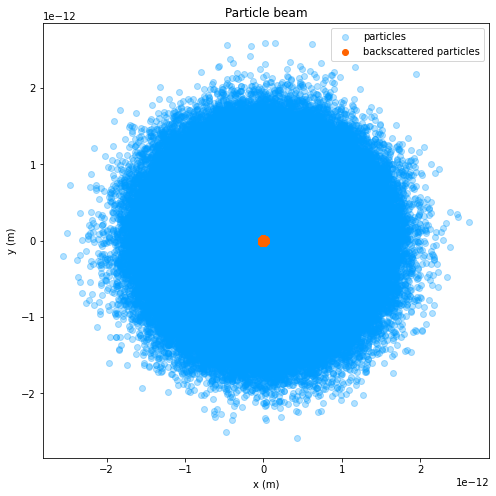

In [11]:
fig, ax = plt.subplots(figsize=(8,8))

ax.set_title("Particle beam")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")

ax.scatter(
    x=beam[0,:], 
    y=beam[1,:],
    color="#009CFF",
    alpha=0.3,
    label="particles"
)
ax.scatter(
    x=beam_backscatter[0,:], 
    y=beam_backscatter[1,:],
    color="#ff6300",
    alpha=1,
    label="backscattered particles"
)

ax.legend()
plt.show()

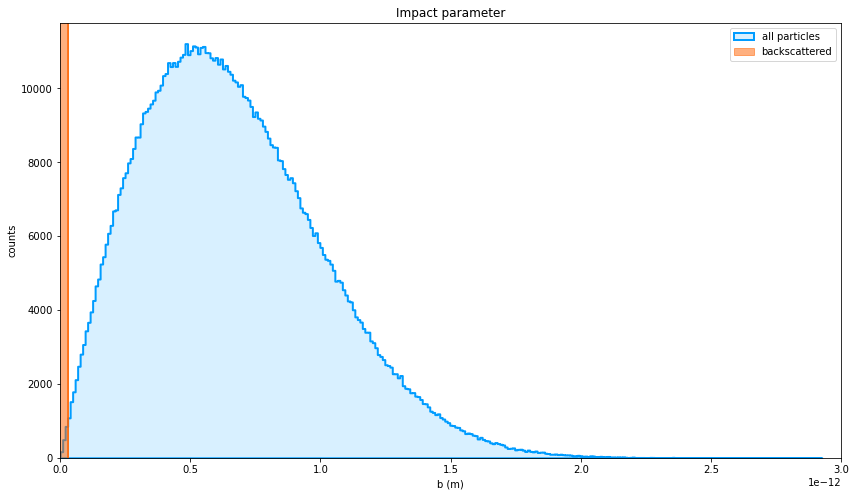

Backscattering condition on impact parameter: 	 b < 2.953e-14 m


In [13]:
fig, ax = plt.subplots(figsize=(14,8))

ax.set_title("Impact parameter")
ax.set_xlabel("b (m)")
ax.set_ylabel("counts")

ax.set_xlim(0, 3e-12)

sns.histplot(
    x           = beam_norm,
    stat        = "count",
    element     = "step",
    fill        = True,
    lw          = 2,
    edgecolor   = "#009CFF",
    color       = "#ccebff",
    label       = "all particles",
    ax=ax
)

ax.axvline(beam_norm_backscatter.max(), color="#ff6300")
ax.axvspan(0, beam_norm_backscatter.max(), alpha=0.5, color="#ff6300", label="backscattered")

ax.legend()
plt.show()

print(f"Backscattering condition on impact parameter: \t b < {beam_norm_backscatter.max():.3e} m")

3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

### Task 3

In [14]:
def f(x):
    """callable of the provided function"""
    return np.sin(1./(x*(2-x)))**2

# number of points 
N       = 10**6
# number of hits
counter = 0
# sum of f(x)
sum     = 0.0
# sum of f(x) squared
sum_sq  = 0.0

# loop over points
for _ in range(N):
    x       = random.rand()*2
    y       = random.rand()
    sum    += f(x)
    sum_sq += f(x)**2
    
    if y<f(x): counter+=1

# hit/miss integral
int_hm = 2*counter/N
# mean value integral
int_mv = 2*sum/N

# lets define p for simplicity
p = sum / N
# error of hit miss integral
err_hm = 2*np.sqrt(N*p*(1-p))/N
# error of mean value integral
err_mv = 2*np.sqrt((sum_sq/N - (sum/N)**2)/N)


print(f"Hit/miss:\t I = {int_hm:.5f} +/- {err_hm:.5f}")
print(f"Mean value:\t I = {int_mv:.5f} +/- {err_mv:.5f}")

Hit/miss:	 I = 1.45172 +/- 0.00089
Mean value:	 I = 1.45180 +/- 0.00053


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



### Task 4

In [36]:
def sphere(x):
    """generic unitary radius spehere in N dimensions""" 
    return 1 if np.sum(x**2) <= 1 else 0
    

# number of points
N = 10**6 

# circle of unit radius
dimension = 2
points2  = random.rand(2*N).reshape(-1,dimension)
counter2 = np.sum([sphere(p) for p in points2])
I2 = 2**dimension * counter2 / N

# 10D sphere
dimension = 10
points10  = random.rand(10*N).reshape(-1,dimension)
counter10 = np.sum([sphere(p) for p in points10])
I10 = 2**dimension *  counter10 / N

print(f"The 2-volume of a disk is {I2:.4f}")
print(f"The 10-volume of a 10d sphere is {I10:.4f}")

The 2-volume of a disk is 3.1397
The 10-volume of a 10d sphere is 2.5999


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

### Task 3

In [19]:
def w(x):
    return 1/(np.sqrt(x))

def f(x):
    return x**-0.5/(np.exp(x)+1)

# number of points
N = 10**6

x = random.rand(N)**2

# integral using importance sampling method
I = 2./N * np.sum(f(x)/w(x))

print(f"Integral: {I:.5f}") # which is close to our expectation

Integral: 0.83935
